In [1]:
import warnings
warnings.filterwarnings("ignore", message=".*`torch.cuda.amp.autocast.*")
import torch
import numpy as np
import random
import PIL.Image
import matplotlib.pyplot as plt
from types import SimpleNamespace
from datasets import load_dataset
from timm.optim import Mars
from torchvision.transforms.v2 import (
    Compose, Resize, RandomCrop, CenterCrop,
    PILToTensor, ToPILImage, CutMix, MixUp )
from fastprogress.fastprogress import master_bar, progress_bar
from IPython.display import display, HTML

In [2]:
torch.set_float32_matmul_precision('highest')
device = "cuda:0"
dataset_train = load_dataset('danjacobellis/imagenet_288_webp',split='train')
dataset_valid = load_dataset('danjacobellis/imagenet_288_webp',split='validation')

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

In [3]:
config = SimpleNamespace()
# Training and optimizer config
config.batch_size = 128
config.steps_per_epoch = dataset_train.num_rows//config.batch_size
config.grad_accum_steps = 1
config.max_lr = (config.batch_size/256)*1e-3
config.min_lr = config.max_lr/100
config.plot_update = 128
config.epochs = 100
config.lr_scale = 0.5
config.lr_offset = 0.2
config.lr_pow = 4
config.weight_decay = 0.0
config.num_workers = 32
config.crop_size = 160
config.valid_crop_size=288

# model config
config.channels = 3
config.classifier_num_classes = 1000
config.checkpoint = False

In [4]:
from timm.models.efficientvit_mit import EfficientVitLarge, GELUTanh
class GroupNorm8(torch.nn.Module):
    def __init__(self, num_features, eps=1e-7, affine=True):
        super().__init__()
        self.groupnorm = torch.nn.GroupNorm(num_groups=8,
                                      num_channels=num_features,
                                      eps=eps,
                                      affine=affine)
    def forward(self, x):
        return self.groupnorm(x)
teacher = EfficientVitLarge(
    in_chans=config.channels,
    widths=(32, 64, 128, 256, 512),
    depths=(1, 1, 1, 6, 6),
    head_dim=32,
    norm_layer=GroupNorm8,
    act_layer=GELUTanh,
    global_pool='avg',
    head_widths=(3072, 3200),
    drop_rate=0.0,
    num_classes=config.classifier_num_classes
).to(device)

In [5]:
from functools import partial
from timm.models.mobilenetv3 import MobileNetV3, decode_arch_def, round_channels

arch_def_small_conv = [
    [
        'cn_r1_k3_s2_e1_c32',
        'cn_r1_k1_s1_e1_c32',
    ],
    [
        'cn_r1_k3_s2_e1_c96',
        'cn_r1_k1_s1_e1_c64',
    ],
    [
        'uir_r1_a5_k5_s2_e3_c96',
        'uir_r4_a0_k3_s1_e2_c96',
        'uir_r1_a3_k0_s1_e4_c96',
    ],
    [
        'uir_r1_a3_k3_s2_e6_c128',
        'uir_r1_a5_k5_s1_e4_c128',
        'uir_r1_a0_k5_s1_e4_c128',
        'uir_r1_a0_k5_s1_e3_c128',
        'uir_r2_a0_k3_s1_e4_c128',
    ],
    [
        'cn_r1_k1_s1_c960',
    ],
]

model = MobileNetV3(
    block_args=decode_arch_def(arch_def_small_conv, group_size=None),
    num_classes=config.classifier_num_classes,
    in_chans=config.channels,
    stem_size=32,
    fix_stem=False,
    num_features=1280,
    head_bias=False,
    head_norm=True,
    pad_type='',
    act_layer=torch.nn.ReLU,
    norm_layer=partial(torch.nn.GroupNorm, eps=1e-5, num_groups=8),
    aa_layer=None,
    se_layer=None,
    se_from_exp=True,
    round_chs_fn=partial(round_channels, multiplier=1.0),
    drop_rate=0.0,
    drop_path_rate=0.0,
    layer_scale_init_value=None, 
    global_pool='avg'
).to(device)

In [6]:
mix_transforms = [
    MixUp(num_classes=config.classifier_num_classes)
]
rand_crop = Compose([
    RandomCrop((config.crop_size,config.crop_size)),
    PILToTensor()
])
cent_crop = Compose([
    CenterCrop(
        size=config.valid_crop_size,
    ),
    PILToTensor()
])


def train_collate_fn(batch):
    B = len(batch)
    x = torch.zeros((B, config.channels, config.crop_size, config.crop_size), dtype=torch.uint8)
    y = torch.zeros(B, dtype=torch.int)
    for i_sample, sample in enumerate(batch):
        y[i_sample] = sample['cls']
        x[i_sample,:,:,:] = rand_crop(sample['webp'])
    x = x.to(torch.float) / 255 - 0.5
    y = y.to(torch.long)
    return x, y

def valid_collate_fn(batch):
    B = len(batch)
    x = torch.zeros((B, config.channels, config.valid_crop_size, config.valid_crop_size), dtype=torch.uint8)
    y = torch.zeros(B, dtype=torch.int)
    for i_sample, sample in enumerate(batch):
        y[i_sample] = sample['cls']
        x[i_sample,:,:,:] = cent_crop(sample['webp'])
    x = x.to(torch.float) / 255 - 0.5
    y = y.to(torch.long)
    return (x,y)

In [7]:
optimizer_teacher = Mars(
    params=teacher.parameters(),
    lr=config.min_lr,
    weight_decay=config.weight_decay,
    caution=True
)

optimizer_student = Mars(
    params=model.parameters(),
    lr=config.min_lr,
    weight_decay=config.weight_decay,
    caution=True
)

def EmPL(x):
    return np.exp(-np.power(np.log(x), config.lr_pow))
        
def EmPL_sched(i_step, config):
    x = i_step / (config.steps_per_epoch/config.plot_update)
    sched = EmPL(x/(config.lr_scale*config.steps_per_epoch/config.plot_update)+config.lr_offset)
    scale = config.max_lr
    lr = scale * sched
    return lr / config.min_lr
    
schedule_teacher = torch.optim.lr_scheduler.LambdaLR(
    optimizer_teacher,
    lr_lambda = lambda i_step: EmPL_sched(i_step, config),
)
    
schedule_student = torch.optim.lr_scheduler.LambdaLR(
    optimizer_student,
    lr_lambda = lambda i_step: EmPL_sched(i_step, config),
)

In [ ]:
# learning_rates = [optimizer.param_groups[0]['lr']]
# i_step = 0
# for i_epoch in range(config.epochs):
#     for i_batch in range(config.steps_per_epoch):
#         if (i_step+1) % config.plot_update == 0:
#             schedule.step()
#             learning_rates.append(optimizer.param_groups[0]['lr'])
#         i_step+=1
# import matplotlib.pyplot as plt
# plt.plot(learning_rates)

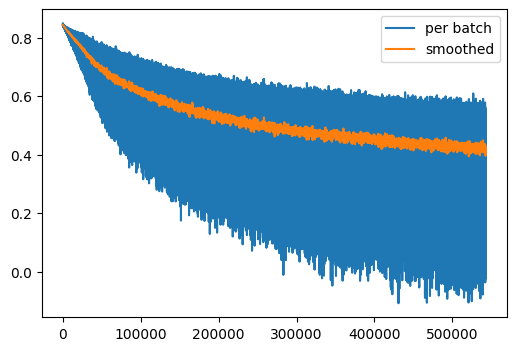

In [ ]:
mb = master_bar(range(config.epochs))
mb.names = ['per batch','smoothed']
train_loss = []
valid_acc = []
learning_rates = [optimizer_teacher.param_groups[0]['lr']]
i_step = 0
for i_epoch in mb:
    # training
    teacher.train()
    model.train()
    dataloader_train = torch.utils.data.DataLoader(
        dataset_train,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers,
        drop_last=True,
        pin_memory=True,
        collate_fn=train_collate_fn
    )
    pb = progress_bar(dataloader_train, parent=mb)
    for i_batch, (x,y) in enumerate(pb):
        y = y.to(torch.long).to(device)
        x = x.to(device)
        for mix_transform in mix_transforms:
            x, y = mix_transform(x, y) 

        teacher_logits = teacher(x)
        teacher_loss = torch.nn.CrossEntropyLoss()(input=teacher_logits, target=y)
        train_loss.append(teacher_loss.item())
        teacher_loss.backward()

        if (i_batch + 1) % config.grad_accum_steps == 0:
            optimizer_teacher.step()
            optimizer_teacher.zero_grad()
        
        student_logits = model(x)
        with torch.no_grad():
            teacher_probs = torch.softmax(teacher_logits, dim=1)
        student_loss = -(teacher_probs * torch.log_softmax(student_logits, dim=1)).sum(dim=1).mean()
        student_loss.backward()
        
        if (i_batch + 1) % config.grad_accum_steps == 0:
            optimizer_student.step()
            optimizer_student.zero_grad()

        # plotting and learning rate update
        if (i_step+1) % config.plot_update == 0:
            plot_n = len(train_loss) // config.plot_update
            smoothed_x = (0.5+torch.arange(plot_n)) * config.plot_update
            smoothed_y = torch.tensor(train_loss).reshape(plot_n, -1).mean(dim=1)
            train_x = range(len(train_loss))
            train_y = train_loss
            mb.update_graph([[train_x, np.log10(train_y)],[smoothed_x, np.log10(smoothed_y)]])

            # lr update
            schedule_teacher.step()
            schedule_student.step()
            learning_rates.append(optimizer_teacher.param_groups[0]['lr'])
    
        i_step+=1
        
    # validation
    model.eval()
    valid_acc.append(0)
    data_loader_valid = torch.utils.data.DataLoader(
        dataset_valid,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        drop_last=False,
        pin_memory=True,
        collate_fn=valid_collate_fn
    )
    pb_valid = progress_bar(data_loader_valid, parent=mb)
    for i_batch, (x, y) in enumerate(pb_valid):
        y = y.to(device)
        x = x.to(device)
        with torch.no_grad():
            logits = model(x)
        valid_acc[i_epoch] += torch.sum(logits.argmax(dim=1) == y).item()
    valid_acc[i_epoch] /= len(dataset_valid)
    
    mb.main_bar.comment = f'valid_acc {valid_acc[i_epoch]:.4g}'
    
    torch.save({
        'i_epoch': i_epoch,
        'learning_rates': learning_rates,
        'smoothed_y': smoothed_y,
        'valid_acc': valid_acc,
        'config': config,
        'model_state_dict': model.state_dict(),
    }, f"log_g_{device}.pth")

In [9]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
display(HTML(mb.main_bar.progress))
display(HTML(mb.child.progress))

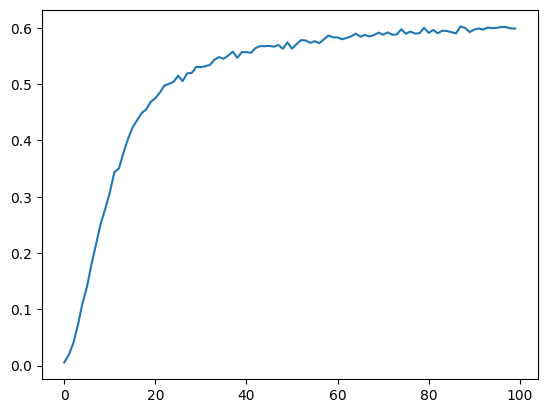

In [10]:
plt.plot(valid_acc)

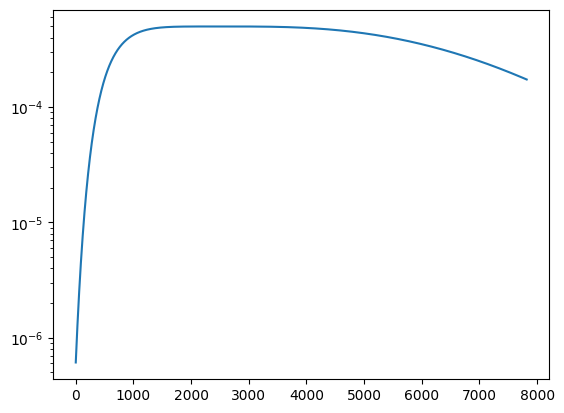

In [11]:
plt.semilogy(learning_rates)

/tmp/ipykernel_1045784/2432266517.py:2: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([0,7])


(1.904242150982289, 7)

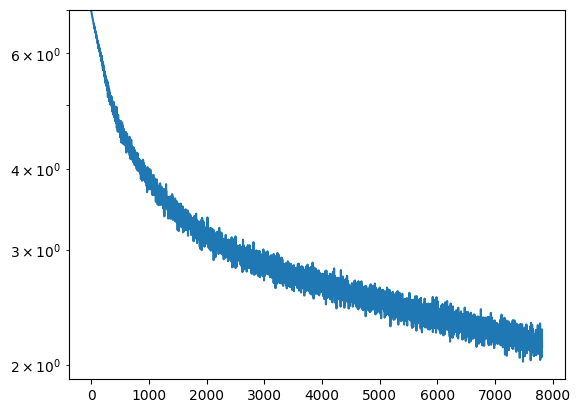

In [12]:
plt.semilogy(smoothed_y)
plt.ylim([0,7])

In [ ]:
# torch.save({
#     'i_epoch': i_epoch,
#     'learning_rates': learning_rates,
#     'smoothed_y': smoothed_y,
#     'valid_acc': valid_acc,
#     'config': config,
#     'model': model.state_dict(),
# }, f"../../hf/tft/tft_wptdrop_v0.1.pth")